In [23]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

import matplotlib
# enable more math expressions in matplotlib labels
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

import inspect
def _acceptable_global(name, value):
    """Returns True if a global variable with name/value can be safely ignored"""
    return (
        # stuff that's normal to share everywhere
        inspect.isroutine(value) or
        inspect.isclass(value) or
        inspect.ismodule(value) or
        # leading underscore marks private variables
        name.startswith('_') or
        # all-caps names indicate constants
        name.upper() == name or
        # ignore IPython stuff
        name in {'In', 'Out'} or 
        getattr(value, '__module__', '').startswith('IPython'))

def assert_globals_clean():
    """Raises an assertion error if there are unmanaged global variables.
       Variables that are considered 'managed' include those formatted with 
       ALL_CAPS (constants), _a_leading_underscore (recognized as a global but at
       least indicated as private to the cell), classes and modules, automatic
       imports from IPython, and functions generally."""
    unmanaged_globals = {k:type(v) for k, v in globals().items() if not _acceptable_global(k, v)}
    if unmanaged_globals != {}:
        raise AssertionError(f"Unmanaged globals found: {unmanaged_globals}")
    ok("No unmanaged globals detected")

from IPython.display import display, Markdown, HTML

def markdown(s):
    return display(Markdown(s))

def html(s):
    return display(HTML(s))

def ok(message="OK"):
    html(f"<div class=\"alert alert-block alert-success\">{message}</div>")

html("""
<style>
.custom-assignment-text {
    background-color: lightyellow;
    border: 1px solid darkkhaki; 
    padding: 10px;
    border-radius: 2px
}
</style>""")

# Fixes space left behind tqdm progress bars with leave=False
# see https://github.com/jupyterlab/jupyterlab/issues/7354
html("""
<style>
.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

def display_table(data, title, headers):
    """Display data in an HTML table inline in the notebook
       data: list of lists of values to put in table rows
       title: to set table caption
       headers: list of table header strings"""
    text = "<table>"
    text += f"<caption>{title}</caption>"
    
    text += "<tr>"
    for h in headers:
        text += f'<th style="text-align:center">{h}</th>'
    text += "</tr>"
    
    for row in data:
        text += "<tr>"
        for value in row:
            text += f"<td>{value}</td>"
        text += "</tr>"
    text += "</table>"
    html(text)

markdown("#### Custom functionality enabled:")
markdown("* Format a code cell by entering %%black at the top of it")
markdown("* Surround markdown cells with  `<div class=\"custom-assignment-text\">\\n\\n ... \\n\\n</div>` to format course-provided assignment text")
markdown("* Use `ok(<message>)` to notify of a passing test")
markdown("* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)")
markdown("* Use `display_table` to display data in an inline HTML table")

#### Custom functionality enabled:

* Format a code cell by entering %%black at the top of it

* Surround markdown cells with  `<div class="custom-assignment-text">\n\n ... \n\n</div>` to format course-provided assignment text

* Use `ok(<message>)` to notify of a passing test

* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)

* Use `display_table` to display data in an inline HTML table

<div class="custom-assignment-text">

## Goal of mini-project

In the three problems of this mini-project, you will explore the idea of generalization, i.e., when the test error of a learned prediction function is roughly the same as its training error. You will explore how regularization and the choice of the learning algorithm (gradient descent, stochastic gradient descent, etc.) interact with generalization in a simple linear prediction setting.1 Many aspects of these relationships are still not well understood, and a fierce debate is currently raging within the Machine Learning community about whether our understanding of generalization lacks key components necessary for explaining the unreasonable effectiveness of stochastic gradient descent (particularly in the context of “deep learning”). This week will give you a glimpse of some of these mysteries.

</div>

<div class="custom-assignment-text">

# Part 1: Regression, Three Ways

<!-- LaTeX shortcuts defined first -->$\def\a{{\mathbf a}}\def\x{{\mathbf x}}$We will consider the problem of fitting a linear model. Given $d$-dimensional input data $\x^{(1)}, \cdots, \x^{(n)} ∈ ℝ^d$ with real-valued labels $y^{(1)},\cdots, y^{(n)} ∈ ℝ$, the goal is to find the coefficient vector $\a$ that minimizes the sum of the squared errors. The total squared error of $\a$ can be written as $f(\a) = \sum_{i=1}^{n} f_i(\a)$, where $f_i(\a)=(\a^\top\x^{(i)} - $ $y^{(i)})^2$ denotes the squared error of the $i$th data point.

The data in this problem will be drawn from the following linear model. For the training data, we select $n$ data points $\x^{(1)}, \cdots, \x^{(n)}$, each drawn independently from a $d$-dimensional Gaussian distribution. We then pick the "true" coefficient vector $\a^*$ (again from a $d$-dimensional Gaussian), and give each training point $\x^{(i)}$ a label equal to $(\a^*)^\top\x^{(i)}$ plus some noise (which is drawn from a 1-dimensional Gaussian distribution).

The following Python code will generate the data used in this problem.

    d = 100 # dimensions of data
    n = 1000 # number of data points
    X = np.random.normal(0,1, size=(n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y = X.dot(a_true) + np.random.normal(0,0.5,size=(n,1))

</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

<div class="custom-assignment-text">

<!-- LaTeX shortcuts defined first -->$\def\X{{\mathbf X}}\def\y{{\mathbf y}}$(a) (4 points) Least-squares regression has the closed form solution $\a = (\X^\top\X)^{-1}\X^\top\y$, which minimizes the squared error on the data. (Here $\X$ is the $n×d$ data matrix as in the code above, with one row per data point, and $y$ is the $n$-vector of their labels.) Solve for $\a$ and report the value of the objective function using this value $\a$. For comparison, what is the total squared error if you just set $\a$ to be the all 0’s vector?

Comment: Computing the closed-form solution requires time $O(nd^2+d^3)$, which is slow for large $d$. Although gradient descent methods will not yield an exact solution, they do give a close approximation in much less time. For the purpose of this assignment, you can use the closed form solution as a good sanity check in the following parts.

</div>

In [3]:
def get_part1_data():
    d = 100 # dimensions of data
    n = 1000 # number of data points
    X = np.random.normal(0,1, size=(n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y = X.dot(a_true) + np.random.normal(0,0.5,size=(n,1))
    return X, y
PART1_X, PART1_Y = get_part1_data()

In [ ]:
def least_squares_regression_closed_form(X, y):
    a = np.linalg.inv(X.T @ X) @ X.T @ y
    assert a.shape == (X.shape[1], 1)
    return a

In [2]:
def error(a, X, y):
    assert a.T.shape[1] == X.shape[-1]
    assert a.shape[0] == X.shape[1]
    return (a.T @ X.T - y.T)

def squared_error(a, X, y):
    return error(a, X, y)**2

def total_squared_error(a, X, y):
    return squared_error(a, X, y).sum()

def mean_squared_error(a, X, y):
    error = squared_error(a, X, y)
    return error.sum() / X.shape[1]

In [6]:
def _estimate_and_report_errors(X, y):
    a_estimate = least_squares_regression_closed_form(X, y)
    a_error = mean_squared_error(a_estimate, X, y)
    all_zeros_error = mean_squared_error(np.zeros((X.shape[1], 1)), X, y)
    markdown(f"* MSE using closed-form solution: {a_error}")
    markdown(f"* MSE using all-zeros solution: {all_zeros_error}")

_estimate_and_report_errors(PART1_X, PART1_Y)

* MSE using closed-form solution: 2.3507321201657976

* MSE using all-zeros solution: 813.0021499802821

<div class="custom-assignment-text">
    
(b) (6 points) In this part, you will solve the same problem via gradient descent on the squared-error
objective function $f(\a) = \sum_{i=1}^n f_i(\a)$. Recall that the gradient of a sum of functions is the sum of their gradients. Given a point $\a_t$, what is the gradient of $f$ at $\a_t$?
    
Now use gradient descent to find a coefficient vector $\a$ that approximately minimizes the least squares
objective function over the data. Run gradient descent three times, once with each of the step sizes
0.00005, 0.0005, and 0.0007. You should initialize $\a$ to be the all-zero vector for all three runs. Plot the objective function value for 20 iterations for all 3 step sizes on the same graph. Comment in 3-4 sentences on how the step size can affect the convergence of gradient descent (feel free to experiment
with other step sizes). Also report the step size that had the best final objective function value and
the corresponding objective function value.
    
</div>

The gradient for MSE given in the lecture notes is as follows:

$\nabla f({\mathbf w}) = \frac{2}{m}\sum_{i=1}^m (E_i({\mathbf w}) \cdot \x^{(i)})$, where $E_i({\mathbf w}) = h_w(\x^{(i)}) - y^{(i)}$.

In [13]:
def mse_gradient(w, X, y):
    """Returns the gradient of MSE at w on X and y"""
    w_error = error(w, X, y)
    grad = np.dot(w_error, X) * 2 / X.shape[0]
    assert grad.shape == (1, X.shape[1])
    return grad

def gradient_descent(X, y, step_size, iterations):
    """Returns (weights, [loss for each iteration])"""
    w = np.zeros((X.shape[1], 1))
    loss = []
    for _ in range(iterations):
        gradient = mse_gradient(w, X, y)
        mse = mean_squared_error(w, X, y)
        loss.append(mse)
        update = step_size * gradient.T
        w -= update
    return w, loss

Step-size,MSE
5e-05,809.8177007375073
0.0005,781.7649804590695
0.0007,769.6405983861399
0.007,476.17009220988496
0.07,12.115781287056102
0.1,4.333678315003198
0.2,2.360251990384154
0.3,2.350760625523213
0.4,2.350732165096832
0.5,2.350740347629249


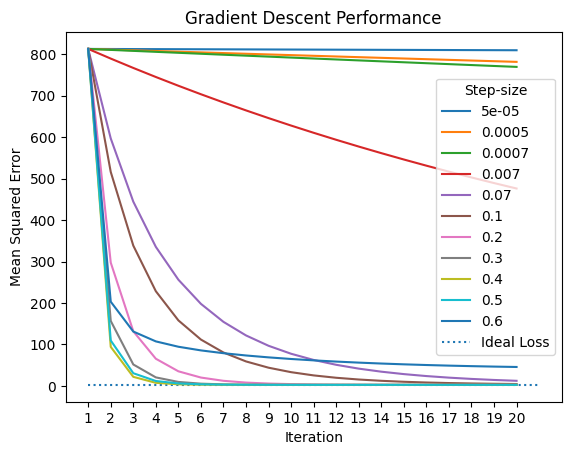

In [8]:
def _run_and_report_gradient_descent(X, y, step_size, ax, iterations=20):
    a, loss = gradient_descent(X, y, step_size, iterations)
    xticks = range(1, iterations + 1)
    ax.plot(xticks, loss, label=step_size)
    return loss[-1]

def _test_gradient_descent_step_sizes(step_sizes, ideal_loss, iterations=20):
    fig, ax = plt.subplots()
    ax.set_title(f"Gradient Descent Performance")
    ax.set_xticks(range(1, iterations + 1))
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Mean Squared Error")
    ax.hlines(ideal_loss, 1, iterations + 1, linestyles='dotted', label="Ideal Loss")
    
    final_losses = []
    for step_size in step_sizes:
        final_loss = _run_and_report_gradient_descent(PART1_X, PART1_Y, step_size, ax, iterations)
        final_losses.append(final_loss)
        
    plt.legend(loc="best", title="Step-size")
    
    display_table(zip(step_sizes, final_losses), "Final MSE by Step-size", ["Step-size", "MSE"])
    
_test_gradient_descent_step_sizes([0.00005, 0.0005, 0.0007, 0.007, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 2.1903207123677566)

Step-sizes .2, .3, .4, and .5 all led to MSE values within 0.01 of the ideal (closed) solution. Higher values, however, led to quicker convergence on this value, with 0.4 being the fastest convering value. 0.5 and higher led to divergence, with 0.7 having such high divergence that it couldn't properly be plotted with the other values.

<div class="custom-assignment-text">

(c) (6 points) In this part you will run _stochastic gradient descent_ to solve the same problem. Recall
that in stochastic gradient descent, you pick one datapoint at a time, say $(\x^{(i)}, y^{(i)})$, and update your current value of $\a$ according to the gradient of $f_i(\a) = (\a\top \x^{(i)} - y^{(i)})^2$.
    
Run stochastic gradient descent using step sizes {0.0005, 0.005, 0.01} and 1000 iterations. Plot the objective function value vs. the iteration number for all 3 step sizes on the same graph. Comment 3-4 sentences on how the step size can affect the convergence of stochastic gradient descent and how it compares to gradient descent. Compare the performance of the two methods. How do the best final objective function values compare? How many times does each algorithm use each data point? Also report the step size that had the best final objective function value and the corresponding objective function value.

</div>

In [3]:
def stochastic_gradient_descent(X, y, step_size, iterations, iter_hook=lambda i, w: None, w_initial=None):
    """Returns (weights, [loss for each iteration])"""
    if w_initial is None:
        w = np.zeros((X.shape[1], 1))
    else:
        w = w_initial
    for i in trange(iterations, desc="SGD Iterations", leave=False):
        row = i % X.shape[0]
        gradient = mse_gradient(w, X[row][:,np.newaxis].T, y[row].T)
        update = step_size * gradient.T
        w -= update
        iter_hook(i, w)
    return w

SGD Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Step-size,MSE
0.0005,121.10613321657364
0.005,5.443596381888185
0.0025,3.614048211348271
0.01,2525.178565259034


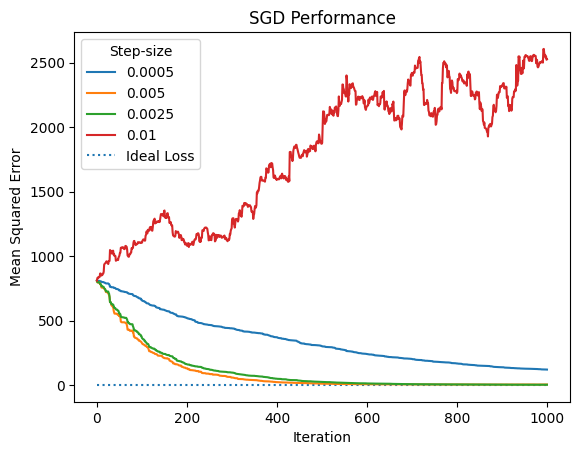

In [10]:
def _run_and_report_sgd(X, y, step_size, ax, iterations=1000):
    loss = []
    a = stochastic_gradient_descent(X, y, step_size, iterations, lambda i, w: loss.append(mean_squared_error(w, X, y)))
    ax.plot(range(iterations), loss, label=step_size)
    return loss[-1]

def _test_sgd_step_sizes(step_sizes, ideal_loss, iterations=1000):
    fig, ax = plt.subplots()
    ax.set_title(f"SGD Performance")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Mean Squared Error")
    ax.hlines(ideal_loss, 1, iterations + 1, linestyles='dotted', label="Ideal Loss")
    
    final_losses = []
    for step_size in step_sizes:
        final_loss = _run_and_report_sgd(PART1_X, PART1_Y, step_size, ax, iterations)
        final_losses.append(final_loss)
        
    plt.legend(loc="best", title="Step-size")
    
    display_table(zip(step_sizes, final_losses), "Final MSE by Step-size", ["Step-size", "MSE"])
    
_test_sgd_step_sizes([0.0005, 0.005, 0.0025, 0.01], 2.1903207123677566)

It's interesting to note that for SGD the step size must be much smaller than for basic gradient descent, and it's also much more sensitive to the change in step size. A value of 0.0025 gave optimal performance with 1,000 iterations for this data set. 0.05 was similar in its speed of convergence to its final value, but 0.0025 gave a better MSE. At 0.01, the algorithm already diverges! Overall, the MSE value achieved was not as good as with plain gradient descent, but the difference was not that large (3 instead of 2, on a scale with a maximum in the thousands).

<div class="custom-assignment-text">

# Part 2
    
In the previous problem, the number of data points was much larger than the number of dimensions and hence we did not worry about generalization. (Feel free to check that the coefficient vector $\a$ that you computed accurately labels new datapoints drawn from the same distribution.) We will now consider the setting where $d = n$, and examine the test error along with the training error. Use the following Python
code for generating the training data and test data.

    train_n = 100
    test_n = 1000
    d = 100
    X_train = np.random.normal(0,1, size=(train_n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
    X_test = np.random.normal(0,1, size=(test_n,d))
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))

</div>

In [21]:
def get_part2_data():
    train_n = 100
    test_n = 1000
    d = 100
    X_train = np.random.normal(0,1, size=(train_n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
    X_test = np.random.normal(0,1, size=(test_n,d))
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))
    return X_train, X_test, y_train, y_test, a_true

PART2_X_TRAIN, PART2_X_TEST, PART2_Y_TRAIN, PART2_Y_TEST, PART2_A_TRUE = get_part2_data()

<div class="custom-assignment-text">

(a) (2 points) We will first setup a baseline, by finding the test error of the linear regression solution $\a = \X^{−1}\y$ without any regularization. This is the closed-form solution for the minimizer of the objective function $f(\a)$. (Note the formula is simpler than in 1(a) because now $\X$ is square.) Report the training error and test error of this approach, averaged over 10 trials. For better interpretability, report the normalized test error $\hat{f}(\a)$ rather than the value of the objective function $f(\a)$, where by definition $\hat{f}(\a) = \frac{||\X\a - \y ||_2}{||\y||_2}$.

</div>

In [19]:
def least_squares_regression_square_closed_form(X, y):
    # X must be square
    assert X.shape[0] == X.shape[1]
    a = np.linalg.inv(X) @ y
    assert a.shape == (X.shape[0], 1)
    return a

def normalized_test_error(a, X_test, y):
    denominator = np.linalg.norm(X_test @ a - y)
    numerator = np.linalg.norm(y)
    return (denominator/numerator).item()

In [24]:
def _run_least_squares_experiment(trials=10):
    train_errors = []
    test_errors = []
    for i in range(trials):
        X_train, X_test, y_train, y_test, _ = get_part2_data()
        a = least_squares_regression_square_closed_form(X_train, y_train)
        train_errors.append(normalized_test_error(a, X_train, y_train))
        test_errors.append(normalized_test_error(a, X_test, y_test))
    display_table(zip(train_errors, test_errors), "Normalized Errors", ["Train", "Test"])
    markdown(f"Mean normalized errors\n* training: {np.mean(train_errors)}\n*test: {np.mean(test_errors)}")
    
_run_least_squares_experiment()

Train,Test
3.133964601960036e-14,0.35330919622302764
1.1464218984942299e-14,1.3053241758190108
1.8655885506235572e-14,0.9626316637145897
2.1652176542146872e-13,4.982377010328496
2.0020512960078793e-14,0.33169912375349064
2.8855974519891196e-14,1.166027624585218
3.2634427715964802e-12,45.90974518373294
9.952084558637874e-15,0.4779058625503501
1.6256666800852306e-14,0.6252255758371755
2.4476239264592384e-14,1.7011980021805098


Mean normalized errors
* training: 3.64098576563278e-13
*test: 5.781544341872481

<div class="custom-assignment-text">


(b) (5 points) We will now examine $\ell_2$ regularization as a means to prevent overfitting. The $\ell_2$ regularized objective function is given by the following expression: $$\sum_{i=1}^m (\a^\top\x^{(i)}-y^{(i)})^2 + \lambda ||\a||^2_2.$$ This has a closed-form solution $\a = (\X^\top\X + \lambda \mathbf I)^{-1}\X^\top\y$. Using this closed-form solution, present a plot of the normalized training error and normalized test error $\hat{f}(\a)$ for λ = {0.0005, 0.005, 0.05, 0.5, 5, 50, 500}.
As before, you should average over 10 trials. Discuss the characteristics of your plot, and also compare it to your answer to (a).

</div>

In [13]:
def regularized_least_squares_closed_form(X, y, lambda_):
    a = np.linalg.inv(X.T @ X + lambda_ * np.eye(X.shape[1])) @ X.T @ y
    assert a.shape == (X.shape[-1], 1)
    return a

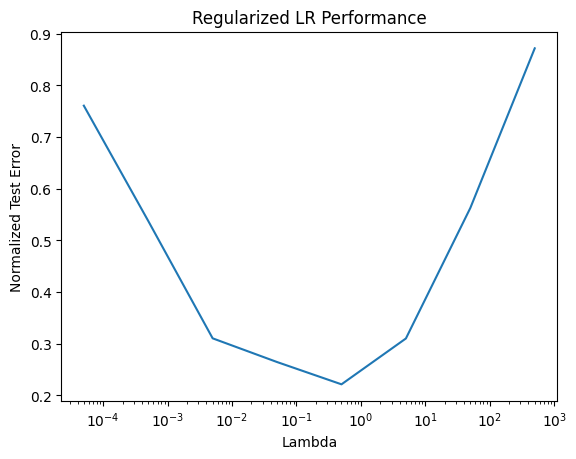

In [14]:
def _run_lambda_experiment(lambda_, data_provider, trials=10):
    errors = []
    for i in range(trials):
        X_train, X_test, y_train, y_test, _ = data_provider()
        a = regularized_least_squares_closed_form(X_train, y_train, lambda_)
        error = normalized_test_error(a, X_test, y_test)
        errors.append([error])
    return np.mean(errors)

def _run_least_squares_regularized_experiment(data_provider=get_part2_data):
    lambdas = [0.00005, 0.0005, 0.005, 0.05, 0.5, 5, 50, 500]
    errors = []
    for lambda_ in lambdas:
        error = _run_lambda_experiment(lambda_, data_provider)
        errors.append(error)
    
    fig, ax = plt.subplots()
    ax.set_title(f"Regularized LR Performance")
    ax.set_xlabel("Lambda")
    ax.set_xscale("log")
    ax.set_ylabel("Normalized Test Error")
    ax.plot(lambdas, errors)
    
_run_least_squares_regularized_experiment()

The plot is much easier to analyze with the $\lambda$ values plotted logarithmically. Values of $\lambda$ too low or too high lead to a higher error value; however, all of the $\lambda$ values tested gave a lower error value than in (a), suggesting that regularization is beneficial even when it hasn't been optimized. The sweet spot is at $\lambda = 0.5$, where the error is 10x less than what it was for the unregularized experiments in (a).

<div class="custom-assignment-text">


(c) (5 points) Run stochastic gradient descent (SGD) on the original objective function $f(\a)$, with the initial guess of a set to be the all 0’s vector. Run SGD for 1,000,000 iterations for each different choice of the step size, {0.00005, 0.0005, 0.005}. Report the normalized training error and the normalized test error for each of these three settings, averaged over 10 repetitions/trials. How does the SGD solution compare with the solutions obtained using $\ell_2$ regularization? Note that SGD is minimizing the original objective function, which does not have any regularization. In Part (a) of this problem, we found the optimal solution to the original objective function with respect to the training data. How does the training and test error of the SGD solutions compare with those of the solution in (a)? Can you explain your observations? (It may be helpful to also compute the normalized training and test error
corresponding to the true coefficient vector $f(\a^*)$, for comparison.)


</div>

In [15]:
def _run_sgd_experiment(X_train, X_test, y_train, y_test, step_size, iterations, trials=10):
    train_error = []
    test_error = []
    for _ in trange(trials, desc="Trials", leave=False):
        a = stochastic_gradient_descent(X_train, y_train, step_size, iterations)
        train_error.append(normalized_test_error(a, X_train, y_train))
        test_error.append(normalized_test_error(a, X_test, y_test))
        
    return np.mean(train_error), np.mean(test_error)

def _test_and_report_sgd_step_sizes():
    data = []
    for step_size in tqdm([0.00005, 0.0005, 0.005], desc="Step sizes"):
        train_error, test_error = _run_sgd_experiment(PART2_X_TRAIN, PART2_X_TEST, PART2_Y_TRAIN, PART2_Y_TEST, step_size, 1_000_000)
        data.append([step_size, train_error, test_error])
    display_table(data, "SGD Performance", ["Step-size", "Train Error", "Test Error"])
    
_test_and_report_sgd_step_sizes()

Step sizes:   0%|          | 0/3 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Step-size,Train Error,Test Error
5e-05,0.009762353108722964,0.17769807600517246
0.0005,0.0026096762039887547,0.24218599774847638
0.005,1.713477723735621e-05,0.31737238438610615


The training error is much lower for the closed-form solution, but SGD outperforms the closed-form solution on test error. Interestingly, the SGD training error goes down as the step-size grows, but the test error goes up. This suggests to me that larger step-sizes allow SGD to fit the data more closely, leading to overfitting. This means that, in a way, a smaller step-size for SGD acts as a regularizer.

<div class="custom-assignment-text">


(d) (7 points) We will now examine the behavior of SGD in more detail. For step sizes {0.00005, 0.005} and 1,000,000 iterations of SGD,
    
* (i) Plot the normalized training error vs. the iteration number. On the plot of training error, draw a line parallel to the x-axis indicating the error $\hat{f}(\a^*)$ of the true model $\a^*$.
* (ii) Plot the normalized test error vs. the iteration number. Your code might take a long time to run if you compute the test error after every SGD step—feel free to compute the test error every 100 iterations of SGD to make the plots.
* (iii) Plot the $\ell_2$ norm of the SGD solution vs. the iteration number.

Comment on the plots. What can you say about the generalization ability of SGD with different step sizes? Does the plot correspond to the intuition that a learning algorithm starts to overfit when the training error becomes too small, i.e. smaller than the noise level of the true model? How does the generalization ability of the final solution depend on the $\ell_2$ norm of the final solution?

</div>

Step Sizes:   0%|          | 0/2 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

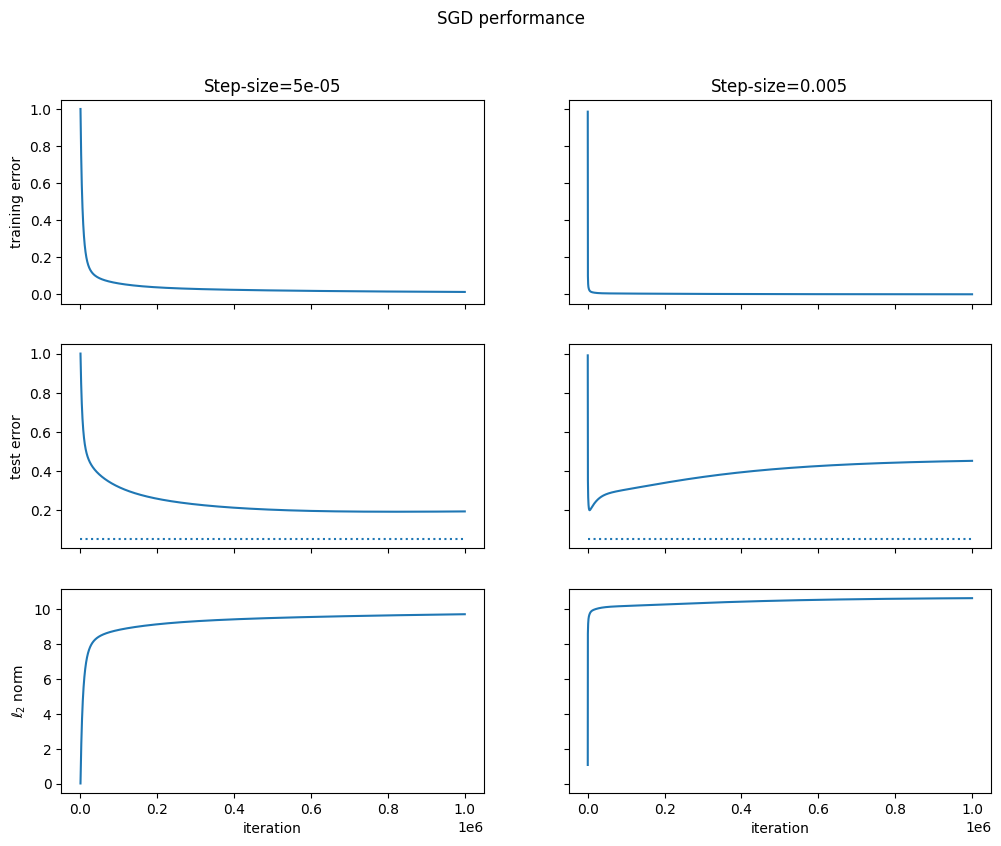

In [76]:
def _get_sgd_stepsize_iteration_data(X_train, X_test, y_train, y_test, step_size, iterations):
    train_error = []
    test_error = []
    l2_norm = []
    plot_data = {"train_error": [], "test_error": [], "l2_norm": [], "x-ticks": []}
    def record_plot_data(i, w):
        if i % 100 == 0:
            plot_data["train_error"].append(normalized_test_error(w, X_train, y_train))
            plot_data["test_error"].append(normalized_test_error(w, X_test, y_test))
            plot_data["l2_norm"].append(np.linalg.norm(w))
            plot_data["x-ticks"].append(i)
            
    stochastic_gradient_descent(X_train, y_train, step_size, iterations, iter_hook=record_plot_data)
    return plot_data

def _plot_sgd_iterations(iterations, step_sizes=[0.00005, 0.005], data_provider=get_part2_data):
    X_train, X_test, y_train, y_test, a_true = data_provider()
    true_error = normalized_test_error(a_true, X_train, y_train)
    
    fig, axs = plt.subplots(3, len(step_sizes), figsize=(12, 9), sharex=True, sharey="row")
    fig.suptitle("SGD performance")
    for ax in axs.flat:
        ax.set_xlabel("iteration")
        
    for i, step_size in tqdm(list(enumerate(step_sizes)), desc="Step Sizes"):
        plot_data = _get_sgd_stepsize_iteration_data(X_train, X_test, y_train, y_test, step_size, iterations)
        x_ticks = plot_data["x-ticks"]
        
        axs[0, i].set_title(f"Step-size={step_size}")
        axs[0, i].plot(x_ticks, plot_data["train_error"])
        axs[0, i].set_ylabel("training error")
        
        axs[1, i].plot(x_ticks, plot_data["test_error"])
        axs[1, i].set_ylabel("test error")
        axs[1, i].hlines(true_error, x_ticks[0], x_ticks[-1], linestyles='dotted', label="True Error")
        
        axs[2, i].plot(x_ticks, plot_data["l2_norm"])
        axs[2, i].set_ylabel("$\ell_2$ norm")
        
        for j in range(3):
            axs[j, i].label_outer()

_plot_sgd_iterations(1_000_000)

SGD appears to generalize better with smaller step sizes. The smaller step size leads to higher training error, lower test error, and a lower $\ell_2$ norm. The higher step-size drops the training data to close to 0 almost immediately, but the test error actually rises over time, approaching a much higher value in the limit than with the small step-size. If this holds more generally, then the observation is quite useful because it gives us a heuristic for knowing when we have chosen a step-size too large. The intuition that a learning algorithm starts to overfit when the training error becomes too small is born out, but it's honestly difficult to say from the plots that "too small" is exactly smaller than the true error, since for both step sizes, the training error became smaller than the true error.

It appears that the higher step-size finds very generalizable weights very quickly; the test error matches that of the smaller step-size in later iterations, and the comparison is the same for the $\ell_2$ norm. The $\ell_2$ norm quickly hits the same value approached with the smaller step-size in later iterations; however, it then rises steadily along with the test error. It's quite interesting to see that there really appears to be a true ideal $\ell_2$ norm, which is approached in the limit using the smaller step-size and is quickly blown past with the larger step size. SGD with smaller step-size really seems to be approximating the $\ell_2$-regularized loss function. I guess that adding smaller gradient values to $\a$ leads to smaller, more conservative estimations of the weights of $\a$, similar to what we model explicitly via $\ell_2$-regularization.

<div class="custom-assignment-text">

(e) (4 points) We will now examine the effect of the starting point on the SGD solution. Fixing the step size at 0.00005 and the maximum number of iterations at 1,000,000, choose the initial point randomly from the $d$-dimensional sphere with radius $r = ${0, 0.1, 0.5, 1, 10, 20, 30}, and plot the average normalized training error and the average normalized test error over 10 trials vs $r$. Comment on the results, in relation to the results from part (b) where you explored different $\ell_2$ regularization coefficients. Can you provide an explanation for the behavior seen in this plot?

</div>

In [17]:
def random_point_on_sphere(radius, dimensions):
    point = np.random.randn(dimensions, 1)
    point /= np.linalg.norm(point, axis=0)
    point *= radius
    return point

Radii:   0%|          | 0/7 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]

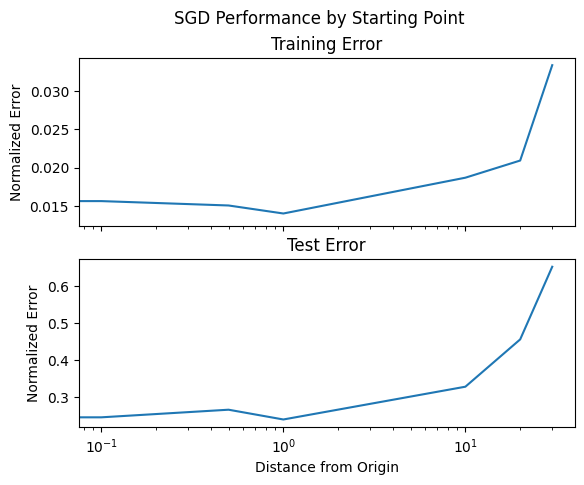

In [18]:
def run_and_report_sgd_starting_point_experiments(iterations, trials, data_provider=get_part2_data):
    radii = [0, 0.1, 0.5, 1, 10, 20, 30]
    train_error_radii = []
    test_error_radii = []
    d = data_provider()[0].shape[1]
    for r in tqdm(radii, desc="Radii"):
        train_error = []
        test_error = []
        for _ in trange(trials, desc="Trials", leave=False):
            w_initial = random_point_on_sphere(r, d)
            X_train, X_test, y_train, y_test, _ = data_provider()
            a = stochastic_gradient_descent(X_train, y_train, 0.00005, iterations, w_initial=w_initial)
            train_error.append(normalized_test_error(a, X_train, y_train))
            test_error.append(normalized_test_error(a, X_test, y_test))
        train_error_radii.append(np.mean(train_error))
        test_error_radii.append(np.mean(test_error))
    
    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle("SGD Performance by Starting Point")
    axs[0].set_title("Training Error")
    axs[0].plot(radii, train_error_radii)
    axs[0].set_ylabel("Normalized Error")
    
    axs[1].set_title("Test Error")
    axs[1].plot(radii, test_error_radii)
    axs[1].set_xlabel("Distance from Origin")
    axs[1].set_xscale("log")
    axs[1].set_ylabel("Normalized Error")

run_and_report_sgd_starting_point_experiments(1_000_000, 10)

The point of $\ell_2$-regularization is to bias the learning algorithm towards weights that are close to the origin, so starting farther and farther away from the origin in SGD can be expected to have a similar effect as a lower $\lambda$ value in $\ell_2$-regularization. From the plots above, we can see that this is born out: larger starting points more negatively affect the test error than the training error, though it eventually has a significantly negative effect on both. I believe that the negative effect is not as strong on the training error because larger starting points can lead to more quickly fitting (and over-fitting) the training set.

<div class="custom-assignment-text">

# Part 3
We will now examine the setting where $d > n$. Choose $d = 200$ and $n = 100$. Use the following Python code for generating the training data and test data.
    
    train_n = 100
    test_n = 10000
    d = 200
    X_train = np.random.normal(0,1, size=(train_n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
    X_test = np.random.normal(0,1, size=(test_n,d))
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))

</div>

In [5]:
def get_part_3a_data(train_n=100, test_n=10_000):
    d = 200
    X_train = np.random.normal(0,1, size=(train_n,d))
    a_true = np.random.normal(0,1, size=(d,1))
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
    X_test = np.random.normal(0,1, size=(test_n,d))
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))
    return X_train, X_test, y_train, y_test, a_true

PART3_X_TRAIN, PART3_X_TEST, PART3_Y_TRAIN, PART3_Y_TEST, PART3_A_TRUE = get_part_3a_data()

<div class="custom-assignment-text">

(a) (5 points: 2 for performance, 3 for analysis and discussion) The goal of this problem is to achieve the best test error that you can, using the techniques from the previous two parts and/or by other means. (Of course, your learning algorithm can only use the training data for this purpose, and cannot refer to a_true.) You will receive credit based on your accuracy. Report the average test error you obtain, averaged over 200 trials (where you re-pick a_true and the data in each trial). Feel free to use regularization, SGD, gradient descent, or any other algorithm you want to try, but clearly describe the algorithm you use in human-readable pseudo-code. Briefly discuss the approach you used, your thought process that informed your decisions, and the extent to which you believe a better test error is achievable. Do make sure that you decide on your final algorithm before running these 200 trials—if you try out a thousand algorithms on all 200 trials, and report the performance of the best one, there is a good chance that the number you report is misleadingly good. (As a sanity check, if you run your re-run your final algorithm on 200 new trials, you should get a similar value for the average performance. . . .) Your score will be based on a combination of the short discussion and the average test error you obtain. A paragraph of discussion is enough to earn full credit—don’t go overboard unless you really want to.

</div>

Radii:   0%|          | 0/7 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

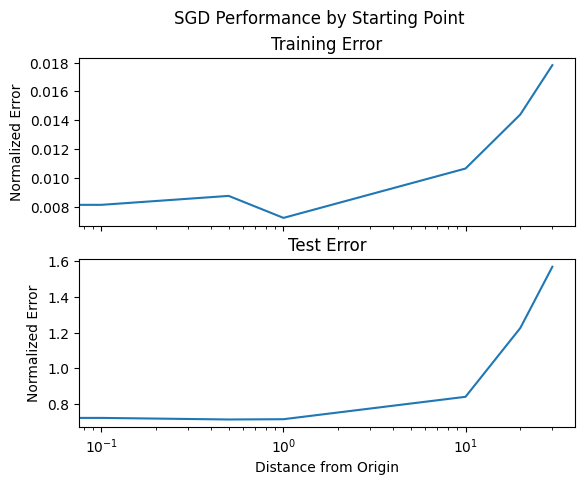

In [20]:
run_and_report_sgd_starting_point_experiments(1_000_00, 10, data_provider=lambda: get_part_3a_data(100, 1000))

Step Sizes:   0%|          | 0/6 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

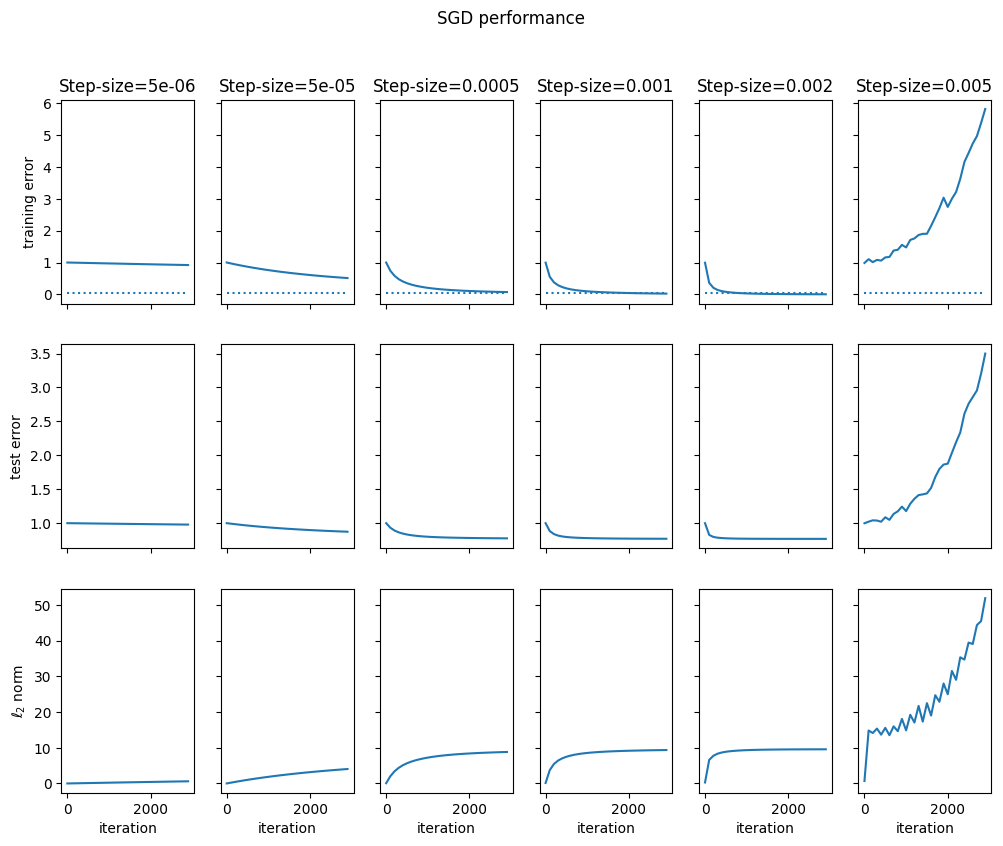

In [21]:
_plot_sgd_iterations(3_000, step_sizes=[0.000005, 0.00005, 0.0005, 0.001, 0.002, 0.005], data_provider=lambda: get_part_3a_data(100, 1000))

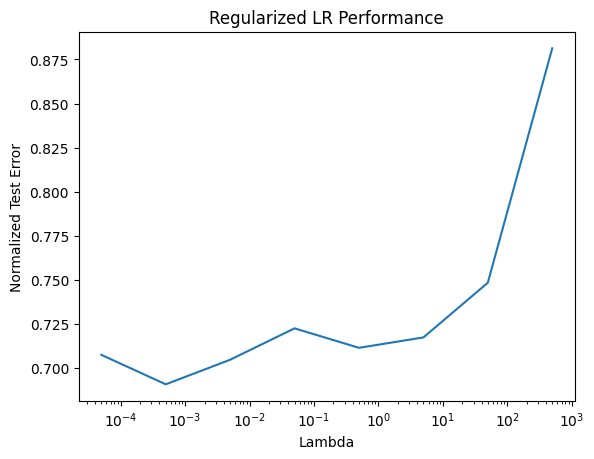

In [22]:
_run_least_squares_regularized_experiment(data_provider=lambda: get_part_3a_data(100, 1000))

I'm only going to use methods discussed in this lesson. I've taken the following information from the previous plots:

* When using SGD, because the test error reaches its asymptotic value quite quickly, and 3,000 iterations are enough to reach the optimum value.
* $\mathbf 0$ still seems to be the optimal starting point for SGD in this scenario, and around 0.002 is the best step-size
* I don't trust the $\ell_2$-regularized closed form very well because the test error seems to depend heavily (and a bit unpredictably) on the choice of $\lambda$.

Therefore, I will use SGD with 3,000 iterations, a starting point of $\mathbf 0$, and a step-size of 0.002.

In [23]:
def _run_sgd_experiment_3a(trials=200):
    train_error = []
    test_error = []
    for _ in trange(trials, desc="Trials"):
        X_train, X_test, y_train, y_test, _ = get_part_3a_data()
        a = stochastic_gradient_descent(X_train, y_train, 0.002, iterations=3_000)
        train_error.append(normalized_test_error(a, X_train, y_train))
        test_error.append(normalized_test_error(a, X_test, y_test))
        
    markdown(f"Average training error over {trials} trials: {np.mean(train_error)}")
    markdown(f"Average test error over {trials} trials: {np.mean(test_error)}")

_run_sgd_experiment_3a(200)

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials: 0.0009333965335015049

Average test error over 200 trials: 0.7064065594482387

<div class="custom-assignment-text">

(b) (6 points: 2 for performance, 4 for analysis and discussion) Repeat part (a) with the following modification that chooses the a_true to be sparse: replace the statement

    a_true = np.random.normal(0,1, size=(d,1))

with

    a_true = np.random.normal(0,1, size=(d,1)) * np.random.binomial(1,0.1, size=(d,1))

Here `np.random.binomial(1,0.1, size=(d,1))` generates a vector in $\{ 0, 1 \}^d$, where the entries are chosen independently, and each entry equals 1 with probability 0.1. `*` denotes entrywise multiplication.

</div>

In [8]:
def get_part_3b_data(train_n=100, test_n=10_000):
    d = 200
    X_train = np.random.normal(0,1, size=(train_n,d))
    a_true = np.random.normal(0,1, size=(d,1)) * np.random.binomial(1,0.1, size=(d,1))
    y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
    X_test = np.random.normal(0,1, size=(test_n,d))
    y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))
    return X_train, X_test, y_train, y_test, a_true

Radii:   0%|          | 0/7 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

Trials:   0%|          | 0/10 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

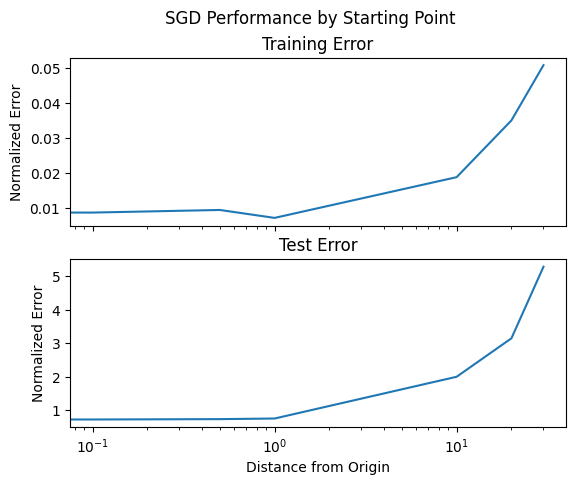

In [25]:
run_and_report_sgd_starting_point_experiments(1_000_00, 10, data_provider=lambda: get_part_3b_data(100, 1000))

Step Sizes:   0%|          | 0/6 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

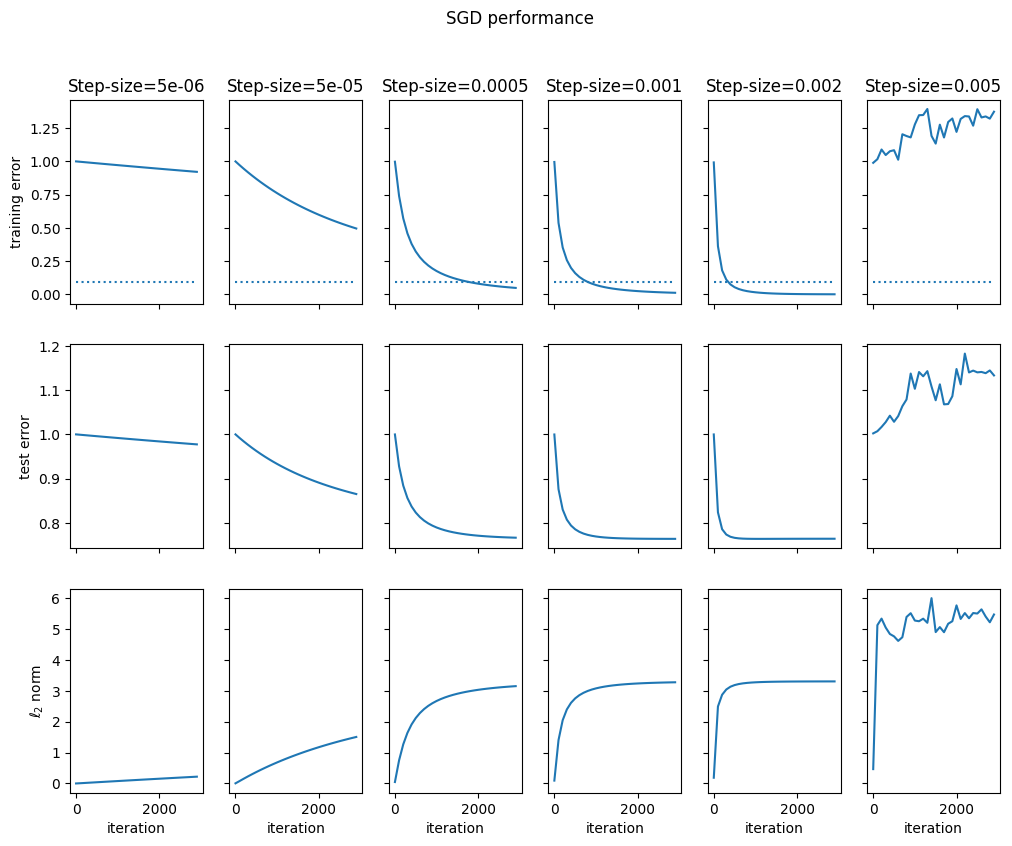

In [26]:
_plot_sgd_iterations(3_000, step_sizes=[0.000005, 0.00005, 0.0005, 0.001, 0.002, 0.005], data_provider=lambda: get_part_3b_data(100, 1000))

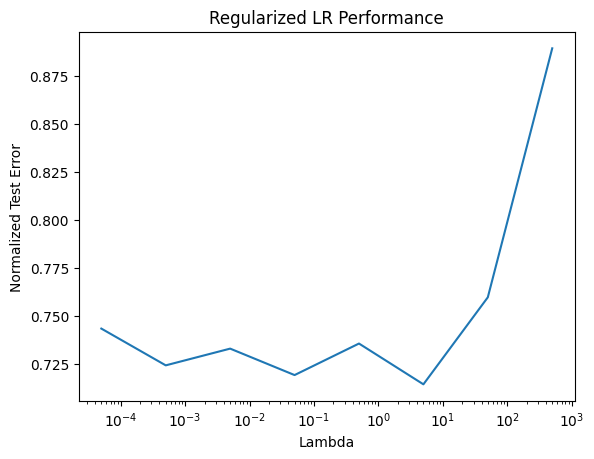

In [27]:
_run_least_squares_regularized_experiment(data_provider=lambda: get_part_3b_data(100, 1000))

The plots above showed basically the same results as in (a), so I will use basically the same approach.

The difference between the data in (a) and (b) is that (b)'s data is roughly 90% sparse, meaning that we know that on average 180 out of 200 dimensions will have a value of zero. We may be able to slightly improve the model by enforcing this fact.

We run SGD for 3,000 iterations with $\mathbf 0$ as the starting weight and a step size of 0.002. Additionally, we will try manually setting the smallest 180 dimensions of $\a$ to 0.

In [75]:
def _run_sgd_experiment_3b(trials=200, trim_dimensions=0):
    train_error = []
    test_error = []
    for _ in trange(trials, desc="Trials", leave=False):
        X_train, X_test, y_train, y_test, _ = get_part_3b_data()
        a = stochastic_gradient_descent(X_train, y_train, 0.002, iterations=3_000)
        # manually set the smallest dimensions to 0, since we know a_true is sparse
        if trim_dimensions:
            smallest_idx = np.argsort(np.abs(a), axis=0)
            a[smallest_idx[:trim_dimensions]] = 0
        train_error.append(normalized_test_error(a, X_train, y_train))
        test_error.append(normalized_test_error(a, X_test, y_test))
        
    markdown(f"Average training error over {trials} trials, trimming {trim_dimensions} dimensions: {np.mean(train_error)}")
    markdown(f"Average test error over {trials} trials, trimming {trim_dimensions} dimensions: {np.mean(test_error)}")

def _test_all_dimension_trimming_3b():
    for trim_dimensions in tqdm([0, 100, 150, 175, 180], desc="Trim Dimensions"):
        _run_sgd_experiment_3b(200, trim_dimensions)
        
_test_all_dimension_trimming_3b()

Trim Dimensions:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, trimming 0 dimensions: 0.0010202494619459357

Average test error over 200 trials, trimming 0 dimensions: 0.7215660738567425

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, trimming 100 dimensions: 0.14886443454900583

Average test error over 200 trials, trimming 100 dimensions: 0.7094843585266927

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, trimming 150 dimensions: 0.2994858110363002

Average test error over 200 trials, trimming 150 dimensions: 0.6657676165038624

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, trimming 175 dimensions: 0.41361832416476974

Average test error over 200 trials, trimming 175 dimensions: 0.6265419567981126

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, trimming 180 dimensions: 0.45456064150974457

Average test error over 200 trials, trimming 180 dimensions: 0.6246784844399401

We tested setting the {0, 10, 150 175, 180} smallest dimensions to 0 and observed the training error become drastically higher while the test error went steadily down, dropping by a total of about 0.1, which is rather significant. It's interesting to note that the SGD performance did not change by increasing iterations, so it seems that the noise in the dataset prevents SGD from directly finding the 0 values. To investigate SGD's behavior in this context, I will plot the average sizes of the sorted weights in $\a$. I expect to see a large difference in the size of the top 20 weights vs the bottom 180.

In [43]:
def _get_all_sgd_weight_vectors(trials, data_provider):
    """Return matrix with `trials` rows; each row is created from the weight vector `a` resulting from 
    running SGD on a generated dataset. Each row is constructed by first taking the absolute value of the entries
    and then sorting ascending by value."""
    all_a = []
    for _ in trange(trials, desc="Trials"):
        X_train, X_test, y_train, y_test, _ = data_provider()
        a = stochastic_gradient_descent(X_train, y_train, 0.002, iterations=3_000)[:,0]
        
        abs_a = np.abs(a)
        smallest_idx = np.argsort(abs_a, axis=0)
        all_a.append(abs_a[smallest_idx])
        
    return np.array(all_a)

def _measure_sparse_dimensions(trials=200, data_provider=get_part_3b_data):
    all_a = _get_all_sgd_weight_vectors(trials, data_provider)
    assert all_a.shape == (trials, 200)
    column_means = np.mean(all_a, axis=0)
    assert column_means.shape == (200,)
    
    fig, ax = plt.subplots()
    ax.plot(list(range(200, 0, -1)), column_means)
    ax.set_title("Average Size of Elements of $\mathbf{a}$")
    ax.set_xlabel("Size Ranking of $\mathbf{a}_i$ (largest to smallest)")
    ax.invert_xaxis()
    ax.set_ylabel("Value of $\mathbf{a}_i$")

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

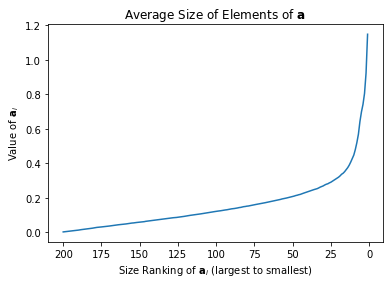

In [44]:
_measure_sparse_dimensions(20)

The expectation is born out. We see that SGD assigns some weight to the bottom 180 weights, meaning that it doesn't directly find sparse dimensions because of the noise hiding them. We see clearly that much more weight is assigned to top 20 dimensions, however. So, although SGD cannot directly assign 0 to sparse dimensions automatically, the nice nice L-curve suggests that we should be able to modify SGD to set the dimensions below the inflection point to 0 and improve the performance on sparse datasets.

One last experiment. If we know SGD is getting "distracted" by noise in the sparse dimensions, then maybe we can improve the performance by re-running SGD with the likely sparse dimensions removed.

In [25]:
def _run_sgd_dimension_removal_experiment(trials=200, remove_dimensions=0, data_provider=get_part_3b_data):
    train_error = []
    test_error = []
    for _ in trange(trials, desc="Trials", leave=False):
        X_train, X_test, y_train, y_test, _ = data_provider()
        a = stochastic_gradient_descent(X_train, y_train, 0.002, iterations=3_000)
        
        # remove smallest dimensions from X and re-run SGD
        if remove_dimensions:
            smallest_idx = np.argsort(np.abs(a), axis=0)
            
            X_train = X_train[:, smallest_idx[remove_dimensions:]]
            X_test = X_test[:, smallest_idx[remove_dimensions:]]
            # remove pesky extra dimensions
            X_test = X_test[:,:,0]
            X_train = X_train[:,:,0]
            
            a = stochastic_gradient_descent(X_train, y_train, 0.002, iterations=3_000)
        
        train_error.append(normalized_test_error(a, X_train, y_train))
        test_error.append(normalized_test_error(a, X_test, y_test))
        
    markdown(f"Average training error over {trials} trials, reduced by {remove_dimensions} dimensions: {np.mean(train_error)}")
    markdown(f"Average test error over {trials} trials, reduced by {remove_dimensions} dimensions: {np.mean(test_error)}")

In [26]:
def _test_all_dimension_removal_3b():
    for remove_dimensions in tqdm([0, 100, 150, 175, 180], desc="Remove Dimensions"):
        _run_sgd_dimension_removal_experiment(200, remove_dimensions)
    
_test_all_dimension_removal_3b()

Remove Dimensions:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 0 dimensions: 0.0010433769752885977

Average test error over 200 trials, reduced by 0 dimensions: 0.7214800270438647

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 100 dimensions: 0.04650666777902565

Average test error over 200 trials, reduced by 100 dimensions: 0.6672379909183971

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 150 dimensions: 0.14216352670916227

Average test error over 200 trials, reduced by 150 dimensions: 0.42153411576318306

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 175 dimensions: 0.22763740748608485

Average test error over 200 trials, reduced by 175 dimensions: 0.3558278263578631

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 180 dimensions: 0.25532823517758774

Average test error over 200 trials, reduced by 180 dimensions: 0.36046084406824647

This is a great result! The relative error is reduced by about half by re-training with the largest 25 dimensions. Interestingly, removing all 180 dimensions is slightly worse than the more conservative 175. Presumably this is because these dimensions are, after all, guesses, and sometimes we maybe accidentally remove non-sparse ones.

### Wait a Second... 3a Redux

In 3b, we saw that we could improve the performance of SGD by re-training after eliminating the features whose effect was likely 0. We knew that there were 180 of these in reality, but on average things worked out better if we removed the smallest 175 because, due to measurement error, sometimes the sparse (meaningless) features would end up with a larger weight than an actually meaningful one.

But this technique could be applied to the non-sparse problem as well; the true features are defined as $X\sim\mathcal{N}(0, 1)$, and the noise (or measurement error) is defined as $E\sim\mathcal{N}(0,0.5)$, so there must be a significant number of features for which the noise happens to be greater than the feature value itself. So we should actually be able to use our method from (3b) to improve the performance of (3a) by finding and eliminating features that are just noise. Let's plot the average $\a_i$ values:

Trials:   0%|          | 0/30 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

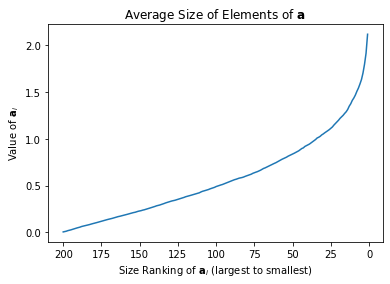

In [45]:
_measure_sparse_dimensions(30, data_provider=get_part_3a_data)

Bingo! We can clearly see that some features are much more informative than others. Surprisingly, the bend in the curve is still around 175 or 180, exactly as in (3b) where we knew for a fact that 180 of the elements of $\X$ had a true value of 0. Let's experiment with removing different numbers of the lowest-weighted dimensions of $\a$:

In [27]:
def _test_all_dimension_removal_3a():
    for remove_dimensions in tqdm([0, 100, 150, 175, 180], desc="Remove Dimensions"):
        _run_sgd_dimension_removal_experiment(200, remove_dimensions, data_provider=get_part_3a_data)
    
_test_all_dimension_removal_3a()

Remove Dimensions:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 0 dimensions: 0.0009945157331405557

Average test error over 200 trials, reduced by 0 dimensions: 0.7065603475283475

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 100 dimensions: 0.06515862263318514

Average test error over 200 trials, reduced by 100 dimensions: 0.7778708153995854

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 150 dimensions: 0.2907827081254808

Average test error over 200 trials, reduced by 150 dimensions: 0.8936064039296154

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 175 dimensions: 0.5148363753918442

Average test error over 200 trials, reduced by 175 dimensions: 0.9414113951509435

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 180 dimensions: 0.5759103325461026

Average test error over 200 trials, reduced by 180 dimensions: 0.9511664340130046

Ick... okay, so the number of dimensions we can safely remove must be much smaller.

In [31]:
def _test_all_dimension_removal_3a_2():
    for remove_dimensions in tqdm(range(1,11), desc="Remove Dimensions"):
        _run_sgd_dimension_removal_experiment(200, remove_dimensions, data_provider=get_part_3a_data)
    
_test_all_dimension_removal_3a_2()

Remove Dimensions:   0%|          | 0/10 [00:00<?, ?it/s]

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 1 dimensions: 0.0010358581507346589

Average test error over 200 trials, reduced by 1 dimensions: 0.7038933429014833

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:01<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 2 dimensions: 0.0010641270016471301

Average test error over 200 trials, reduced by 2 dimensions: 0.7089871174440475

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 3 dimensions: 0.0011050044745362871

Average test error over 200 trials, reduced by 3 dimensions: 0.7130502357134987

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 4 dimensions: 0.0013131512321920371

Average test error over 200 trials, reduced by 4 dimensions: 0.709903942110336

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 5 dimensions: 0.001318018792041396

Average test error over 200 trials, reduced by 5 dimensions: 0.7070715214961979

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 6 dimensions: 0.0013222232812048463

Average test error over 200 trials, reduced by 6 dimensions: 0.7102728619377726

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 7 dimensions: 0.0014477700354646322

Average test error over 200 trials, reduced by 7 dimensions: 0.7086945884162961

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 8 dimensions: 0.0014167575215178444

Average test error over 200 trials, reduced by 8 dimensions: 0.7092005106167687

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 9 dimensions: 0.0014967445877645032

Average test error over 200 trials, reduced by 9 dimensions: 0.7083277398811433

Trials:   0%|          | 0/200 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

SGD Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

Average training error over 200 trials, reduced by 10 dimensions: 0.0015315572364645769

Average test error over 200 trials, reduced by 10 dimensions: 0.7096302393769142

🤷 So it seems that even removing a small number of dimensions using this naive approach hurts performance in the case that none of the dimensions are likely to have a true value of 0. I will await treatment of more sophisticated methods of dimensionality reduction in future lectures.

In [46]:
assert_globals_clean()